# 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

## Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

## Setup and Import Libraries

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embedding = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Document Loading and Create Vector Database

In [5]:
documents = TextLoader(file_path="internal_docs.txt").load()

chunks = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
).split_documents(documents=documents)

In [6]:
vector_store = FAISS.from_documents(
    documents=chunks, embedding=embedding
)

retriever = vector_store.as_retriever()

## State Definition

In [7]:
class RAGReflectionState(BaseModel):
    question: str
    retrieved_document: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

## Nodes

### Retrieve

In [8]:
def retrieve_documents(state: RAGReflectionState)-> RAGReflectionState:
    documents = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_document": documents})

### Generate Answer

In [9]:
def generate_answer(state: RAGReflectionState)-> RAGReflectionState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_document])
    prompt = f"""
    Use the following context to answer the question:

    Context:
    {context}

    Question:
    {state.question}
    """
    
    answer = llm.invoke(input=prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts" : state.attempts + 1})

### Self-Reflect

In [10]:
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    prompt = f"""
    Reflect on the following answer to see if it fully addresses the question. 
    State YES if it is complete and correct, or NO with an explanation.

    Question: {state.question}

    Answer: {state.answer}

    Respond like:
    Reflection: YES or NO
    Explanation: ...
    """

    result = llm.invoke(input=prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})


### Final Answer

In [11]:
def finalize(state: RAGReflectionState)-> RAGReflectionState:
    return state

## LangGraph Workflow

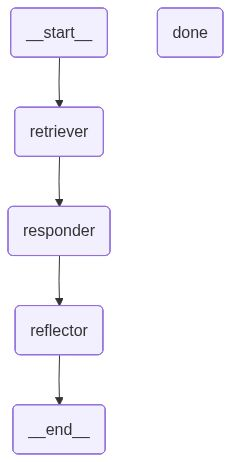

In [12]:
builder = StateGraph(RAGReflectionState)

## Add Nodes
builder.add_node(node="retriever", action=retrieve_documents)
builder.add_node(node="responder", action=generate_answer)
builder.add_node(node="reflector", action=reflect_on_answer)
builder.add_node(node="done", action=finalize)

## Set Entry Point
builder.set_entry_point(key="retriever")

## Add Edges
builder.add_edge(start_key="retriever", end_key="responder")
builder.add_edge(start_key="responder", end_key="reflector")
builder.add_conditional_edges(
    source="reflector",
    path=lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
)

builder.add_edge(start_key="done", end_key=END)

## Compile Graph
graph = builder.compile()

## Display Graph
graph

## Query

In [13]:
user_query = "What are the transformer variants in production deployments?"

init_state = RAGReflectionState(question=user_query)
result = graph.invoke(init_state)

print("\n🧠 Final Answer:\n", result["answer"])
print("\n🔁 Reflection Log:\n", result["reflection"])
print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 The transformer variants used in production deployments are:

1. EfficientFormer
2. Vision transformers (ViT and Swin Transformer)
3. Speech transformers (Wav2Vec 2.0)
4. Reformer

🔁 Reflection Log:
 Reflection: NO  
Explanation: While the answer lists some significant transformer variants used in production, it is not exhaustive and misses several other commonly deployed variants. Notably missing are BERT (and its derivatives like RoBERTa, DistilBERT), GPT (especially GPT-2 and GPT-3), T5, XLNet, and Longformer, which are widely used in natural language processing tasks. Additionally, other notable variants include transformers in different application domains like DETR for object detection and timeseries transformers. The answer should include a wider range of variants to fully address the question comprehensively.
🔄 Total Attempts: 2
